In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import os

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder

from IPython import display
from PIL import Image

In [2]:
!pip install torchinfo
from torchinfo import summary

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download "paultimothymooney/chest-xray-pneumonia"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:18<00:00, 248MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s]


In [5]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
transform_data = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

In [8]:
def load_image(image_path, title):
    image = Image.open(image_path).convert('RGB')
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.show()
    image = transform_data(image).unsqueeze(0)
    return image.to(device)

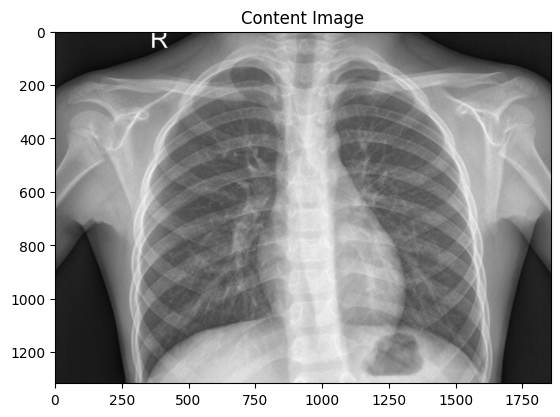

In [9]:
content_image_path = "/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg"
content_image = load_image(content_image_path, "Content Image")

In [10]:
data_dir_tr = '/content/chest_xray/chest_xray/train'

datas_tr = ImageFolder(root=data_dir_tr,
                   transform=transform_data)

In [11]:
datas_tr

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /content/chest_xray/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [12]:
data_dir_tt = '/content/chest_xray/chest_xray/test'

datas_tt = ImageFolder(root=data_dir_tt,
                   transform=transform_data)

In [13]:
datas_tt

Dataset ImageFolder
    Number of datapoints: 624
    Root location: /content/chest_xray/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

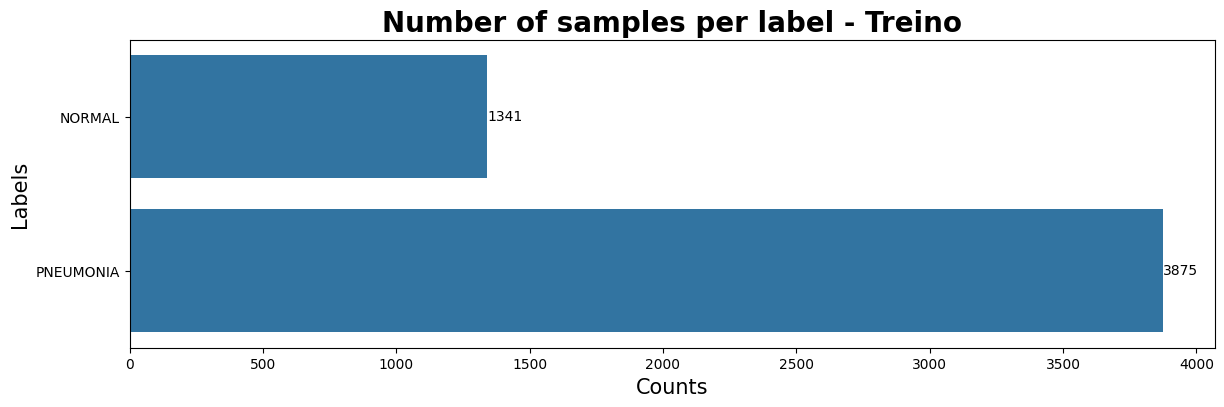

In [14]:
classes = datas_tr.classes
counts = [0] * len(classes)

for img in datas_tr.imgs:
    counts[img[1]] += 1

plt.figure(figsize=(14,4))
ax = sns.barplot(x=counts, y=classes)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label - Treino', fontsize=20, fontweight='bold')
plt.xlabel('Counts', fontsize=15)
plt.ylabel('Labels', fontsize=15)
plt.show();

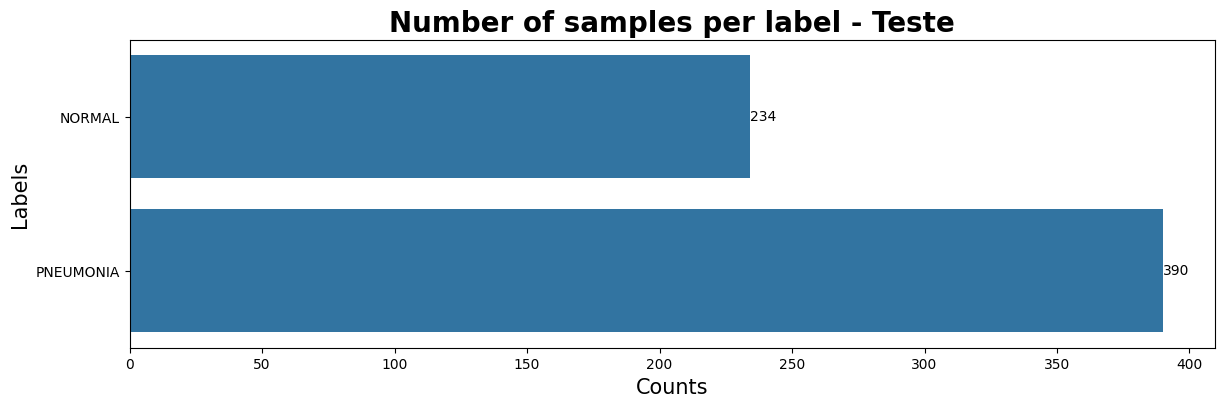

In [15]:
classes = datas_tt.classes
counts = [0] * len(classes)

for img in datas_tt.imgs:
    counts[img[1]] += 1

plt.figure(figsize=(14,4))
ax = sns.barplot(x=counts, y=classes)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label - Teste', fontsize=20, fontweight='bold')
plt.xlabel('Counts', fontsize=15)
plt.ylabel('Labels', fontsize=15)
plt.show();

In [16]:
print(f"Tamanho do conjunto de treinamento: {len(datas_tr)}")
print(f"Tamanho do conjunto de teste: {len(datas_tt)}")

Tamanho do conjunto de treinamento: 5216
Tamanho do conjunto de teste: 624


In [17]:
batch_size_train = 32
batch_size_val   = 32

# Carregar os dados em DataLoaders
trainloader = DataLoader(datas_tr, batch_size=batch_size_train, shuffle=True, drop_last = True)
testloader = DataLoader(datas_tt, batch_size=batch_size_val, shuffle=True, drop_last = True)

In [18]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # Carregar o modelo VGG16 pré-treinado
        self.model = models.vgg16(pretrained=True)

        # Congelar os parâmetros do modelo para que não sejam atualizados durante o treinamento
        for param in self.model.parameters():
            param.requires_grad = False

        # Substituir a camada de pooling adaptativo, se necessário
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # Substituir a camada classifier com uma nova sequência de camadas
        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.model(x)

In [19]:
# Force using the correct `to` method from torch.nn.Module
VGG_summary = VGG()._apply(lambda x: x.to(torch.device(device))).eval()  # Added _apply

# Get and print the model summary
summary(VGG_summary, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 161MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─VGG: 1-1                               [1, 2]                    --
│    └─Sequential: 2-1                   [1, 512, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                  [1, 64, 224, 224]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-6                  [1, 128, 112, 112]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-8                  [1, 128, 112, 112]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 56, 56]    

In [20]:
# Inicializar o modelo
model = VGG().to(device)

# Definir a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Inicializar listas para armazenar as acurácias
train_accuracies = []
val_accuracies = []
epochs_list = []

print("Fase de Treino")
for epoch in range(5):
    running_loss = 0.0

    # Treinamento
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        opt.zero_grad()  # Zera os gradientes antes do forward pass

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        opt.step()

        running_loss += loss.item()
        if i % 10 == 0:
            print('[%d, %5d] perda: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

    # Avaliação do modelo no conjunto de treino
    model.eval()
    correct_train = 0
    total_train = 0

    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    acuracia_treino = 100 * correct_train / total_train
    train_accuracies.append(acuracia_treino)

    # Avaliação do modelo no conjunto de teste
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    acuracia_teste = 100 * correct_test / total_test
    val_accuracies.append(acuracia_teste)

    epochs_list.append(epoch + 1)

    print(f'Época {epoch+1} - Acurácia no conjunto de treino: {acuracia_treino:.2f}%')
    print(f'Época {epoch+1} - Acurácia no conjunto de teste: {acuracia_teste:.2f}%')
    print(" ")

print(f"Terminou o treinamento do modelo: {model.__class__.__name__}")
print("-" * 50)

Fase de Treino
[1,     1] perda: 0.079
[1,    11] perda: 0.748
[1,    21] perda: 0.545
[1,    31] perda: 0.573
[1,    41] perda: 0.412
[1,    51] perda: 0.267
[1,    61] perda: 0.224
[1,    71] perda: 0.183
[1,    81] perda: 0.212
[1,    91] perda: 0.138
[1,   101] perda: 0.138
[1,   111] perda: 0.143
[1,   121] perda: 0.138
[1,   131] perda: 0.132
[1,   141] perda: 0.111
[1,   151] perda: 0.157
[1,   161] perda: 0.137
Época 1 - Acurácia no conjunto de treino: 96.32%
Época 1 - Acurácia no conjunto de teste: 83.22%
 
[2,     1] perda: 0.014
[2,    11] perda: 0.112
[2,    21] perda: 0.105
[2,    31] perda: 0.143
[2,    41] perda: 0.120
[2,    51] perda: 0.125
[2,    61] perda: 0.122
[2,    71] perda: 0.115
[2,    81] perda: 0.112
[2,    91] perda: 0.096
[2,   101] perda: 0.099
[2,   111] perda: 0.072
[2,   121] perda: 0.066
[2,   131] perda: 0.094
[2,   141] perda: 0.080
[2,   151] perda: 0.124
[2,   161] perda: 0.091
Época 2 - Acurácia no conjunto de treino: 97.18%
Época 2 - Acurácia no

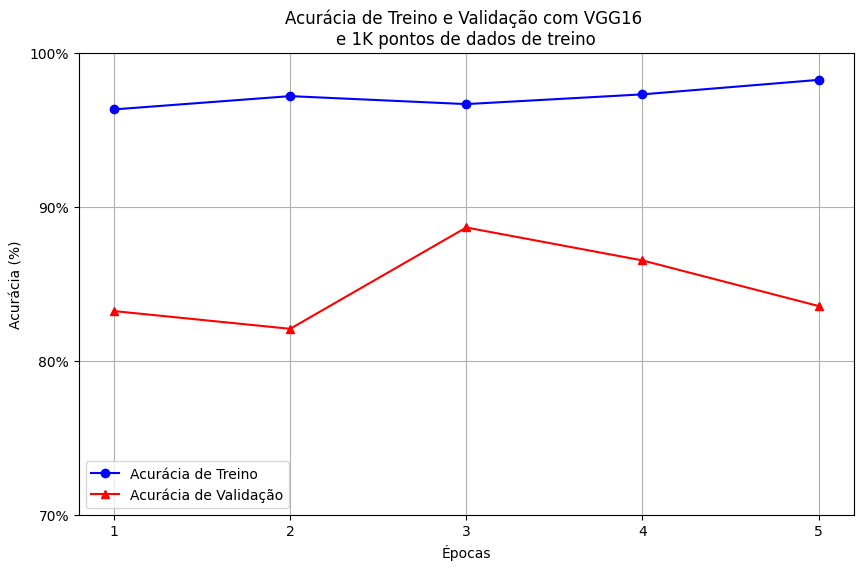

In [21]:
# Plotar as acurácias
plt.figure(figsize=(10,6))
plt.plot(epochs_list, train_accuracies, 'bo-', label='Acurácia de Treino')
plt.plot(epochs_list, val_accuracies, 'r^-', label='Acurácia de Validação')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Acurácia de Treino e Validação com VGG16 \ne 1K pontos de dados de treino')
plt.xlabel('Épocas')
plt.ylabel('Acurácia (%)')
plt.gca().set_yticks(np.arange(70, 101, 10))  # Define ticks de 0% a 100% com passos de 10%
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid(True)
plt.show()